In [2]:
pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 30.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 23.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost==1.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 MB 8.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


GPU 포트 바꾸기

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


In [3]:
# 전처리 한 파일 불러오기
train = pd.read_csv('./data/processing/train_preprocessed.csv', index_col=0)
train.head()

,num,date_time,temp,prec,wind,hum,power,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,20220601 00,18.6,0.0,0.9,42.0,1085.28,2,6,22,1774.744615,1706.318118,446.882767,0,0.000000,1.000000,49.6576,-7.4
1,1,20220601 01,18.0,0.0,1.1,45.0,1047.36,2,6,22,1687.347692,1622.620235,439.662704,0,0.258819,0.965926,47.7625,-15.4
2,1,20220601 02,17.7,0.0,1.5,45.0,974.88,2,6,22,1571.483077,1506.971294,412.071906,0,0.500000,0.866025,47.2225,-23.7
3,1,20220601 03,16.7,0.0,1.4,48.0,953.76,2,6,22,1522.153846,1437.365647,391.205981,0,0.707107,0.707107,44.7856,-33.0
4,1,20220601 04,18.4,0.0,2.8,43.0,986.40,2,6,22,1506.793846,1447.321412,381.099697,0,0.866025,0.500000,49.0061,-40.6


train data shape
x:(1872, 15), y:(1872,)


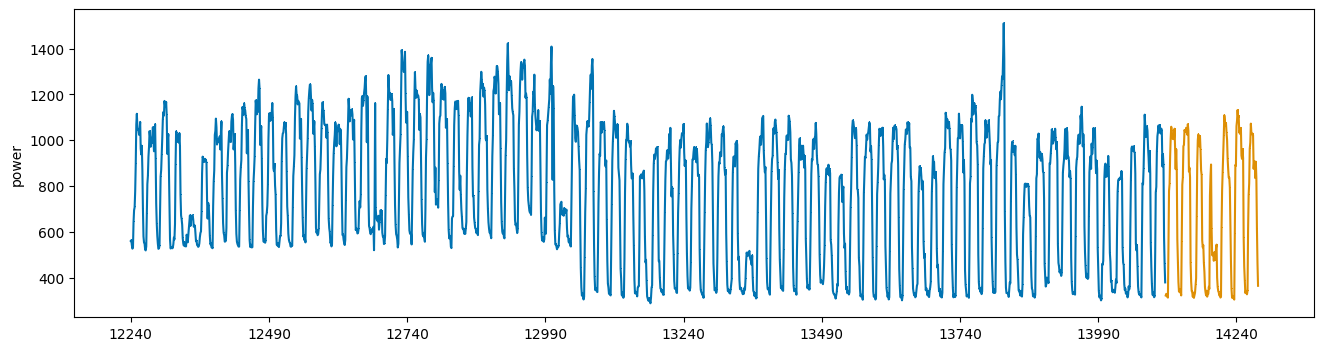

In [5]:
## 7번 건물의 발전량
## 마지막 일주일 발전량을 validset으로
y = train.loc[train.num == 7, 'power']
x = train.loc[train.num == 7, ].iloc[:, 3:]

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

## model tuning

평가 Metric SMAPE은 과소적합보다 과대적합이 더 좋은 점수를 띔

In [6]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [7]:
print("실제값이 100일 때 50으로 underestimate할 때의 SMAPE : {}".format(SMAPE(100, 50)))
print("실제값이 100일 때 150으로 overestimate할 때의 SMAPE : {}".format(SMAPE(100, 150)))

실제값이 100일 때 50으로 underestimate할 때의 SMAPE : 33.33333333333333
실제값이 100일 때 150으로 overestimate할 때의 SMAPE : 20.0


#### 그러나 일반 mse를 objective function으로 훈련할 때 과소추정하는 건물들이 있음을 확인했습니다.
#### 이때문에 SMAPE 점수가 높아진다고 판단, 이를 해결하기 위해 아래와 같이 objective function을 새로 정의했습니다.
#### 새 목적함수는 residual이 0보다 클 때, 즉 실제값보다 낮게 추정할 때 alpha만큼의 가중치를 곱해 반영합니다.

#### XGBoost는 custom objective function으로 훈련하기 위해선 아래와 같이
#### gradient(1차 미분함수) / hessian(2차 미분함수)를 정의해 두 값을 return해주어야 합니다.

In [8]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [9]:
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

In [10]:
train.columns

Index(['num', 'date_time', 'temp', 'prec', 'wind', 'hum', 'power', 'day',
       'month', 'week', 'day_hour_mean', 'hour_mean', 'hour_std', 'holiday',
       'sin_time', 'cos_time', 'THI', 'CDH'],
      dtype='object')

In [11]:
# 슬라이싱을 편하게 하기 위해 power 열을 temp 열과 바꿈
train = train[['num', 'date_time', 'power', 'prec', 'wind', 'hum', 'temp', 'day',
       'month', 'week', 'day_hour_mean', 'hour_mean', 'hour_std', 'holiday',
       'sin_time', 'cos_time', 'THI', 'CDH']]

train.head()

,num,date_time,power,prec,wind,hum,temp,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,20220601 00,1085.28,0.0,0.9,42.0,18.6,2,6,22,1774.744615,1706.318118,446.882767,0,0.000000,1.000000,49.6576,-7.4
1,1,20220601 01,1047.36,0.0,1.1,45.0,18.0,2,6,22,1687.347692,1622.620235,439.662704,0,0.258819,0.965926,47.7625,-15.4
2,1,20220601 02,974.88,0.0,1.5,45.0,17.7,2,6,22,1571.483077,1506.971294,412.071906,0,0.500000,0.866025,47.2225,-23.7
3,1,20220601 03,953.76,0.0,1.4,48.0,16.7,2,6,22,1522.153846,1437.365647,391.205981,0,0.707107,0.707107,44.7856,-33.0
4,1,20220601 04,986.40,0.0,2.8,43.0,18.4,2,6,22,1506.793846,1447.321412,381.099697,0,0.866025,0.500000,49.0061,-40.6


In [13]:
## gridsearchCV for best model : 대략 1시간 소요
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1),
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
        'subsample' :np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)

# 건물 번호별로 GridSearch로 parameter 생성
for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i, ].iloc[:, 3:]
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)


    # pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 42, gpu_id = 0,
                                                tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
                       param_grid = grid, scoring = smape, cv = 5, refit = True, verbose = True)


    gcv.fit(x, y)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)

  0%|          | 0/100 [00:00<?, ?it/s]/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Fitting 5 folds for each of 168 candidates, totalling 840 fits


  1%|          | 1/100 [02:43<4:30:20, 163.84s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building1|| SMAPE : 22.365774653943944
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  2%|▏         | 2/100 [05:18<4:18:57, 158.54s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building2|| SMAPE : 21.544826565306177
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  3%|▎         | 3/100 [08:10<4:25:46, 164.40s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building3|| SMAPE : 18.396378433196205
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  4%|▍         | 4/100 [09:56<3:46:16, 141.42s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building4|| SMAPE : 21.733351148925586
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  5%|▌         | 5/100 [12:38<3:56:03, 149.09s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building5|| SMAPE : 23.357780935018482
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  6%|▌         | 6/100 [14:40<3:38:53, 139.71s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building6|| SMAPE : 23.531123846865736
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  7%|▋         | 7/100 [17:06<3:39:45, 141.78s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building7|| SMAPE : 20.862697241921698
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  8%|▊         | 8/100 [18:45<3:16:29, 128.14s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building8|| SMAPE : 22.506707931953642
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  9%|▉         | 9/100 [20:58<3:16:46, 129.74s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building9|| SMAPE : 22.669339824525508
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 10%|█         | 10/100 [22:48<3:05:35, 123.73s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building10|| SMAPE : 20.010908879416036
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 11%|█         | 11/100 [24:26<2:51:29, 115.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building11|| SMAPE : 21.68682118229532
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 12%|█▏        | 12/100 [26:18<2:48:01, 114.56s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building12|| SMAPE : 22.70553138603034
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 13%|█▎        | 13/100 [28:03<2:42:04, 111.77s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building13|| SMAPE : 22.399653838853624
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 14%|█▍        | 14/100 [30:29<2:54:58, 122.08s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building14|| SMAPE : 19.92240375836166
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 15%|█▌        | 15/100 [32:07<2:42:27, 114.68s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building15|| SMAPE : 21.398952175607818
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 16%|█▌        | 16/100 [34:06<2:42:37, 116.16s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building16|| SMAPE : 21.442097361477888
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 17%|█▋        | 17/100 [36:28<2:51:26, 123.93s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building17|| SMAPE : 23.491787833127383
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 18%|█▊        | 18/100 [38:35<2:50:38, 124.86s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building18|| SMAPE : 23.99980073357872
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 19%|█▉        | 19/100 [40:56<2:54:49, 129.50s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building19|| SMAPE : 24.648347081477613
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 20%|██        | 20/100 [43:10<2:54:29, 130.87s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building20|| SMAPE : 23.116823286124617
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 21%|██        | 21/100 [45:14<2:49:38, 128.85s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building21|| SMAPE : 22.93759937706796
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 22%|██▏       | 22/100 [46:51<2:35:17, 119.45s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building22|| SMAPE : 22.74171141530364
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 23%|██▎       | 23/100 [48:20<2:21:39, 110.39s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building23|| SMAPE : 22.766704341234107
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 24%|██▍       | 24/100 [50:18<2:22:23, 112.42s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building24|| SMAPE : 22.379428171191577
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 25%|██▌       | 25/100 [52:10<2:20:34, 112.46s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building25|| SMAPE : 23.263782768838112
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 26%|██▌       | 26/100 [54:01<2:18:06, 111.98s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building26|| SMAPE : 22.476489521735374
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 27%|██▋       | 27/100 [55:43<2:12:24, 108.83s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building27|| SMAPE : 21.721890455173927
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 28%|██▊       | 28/100 [57:40<2:13:33, 111.29s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building28|| SMAPE : 20.95259245114629
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 29%|██▉       | 29/100 [59:30<2:11:29, 111.12s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building29|| SMAPE : 21.677704183200778
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 30%|███       | 30/100 [1:01:54<2:20:53, 120.77s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building30|| SMAPE : 22.155391512255544
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 31%|███       | 31/100 [1:03:46<2:16:05, 118.35s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building31|| SMAPE : 21.04434324997865
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 32%|███▏      | 32/100 [1:04:41<1:52:35, 99.35s/it] 

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building32|| SMAPE : 22.279155681191906
Fitting 5 folds for each of 168 candidates, totalling 840 fits


/home/mskang/.conda/envs/server/lib/python3.9/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
df.to_csv('./energy/hyperparameter_xgb.csv', index = False) # save the tuned parameters